In [23]:
from LorenzEDMD.EDMD.EDMD import EDMD_CHEB
from matplotlib import pyplot as plt
import numpy as np
import pickle
from LorenzEDMD.utils.data_processing import get_spectral_properties , normalise_data_chebyshev, get_acf
from LorenzEDMD.dynamical_system.Lorenz import lorenz63
from LorenzEDMD.EDMD.EDMD import Tikhonov, TSVD
import matplotlib
matplotlib.rcParams.update({
    "text.usetex": True,  # Use LaTeX to render text
    "font.family": "serif",  # Use serif font (default in LaTeX)
    "text.latex.preamble": r"\usepackage{amsmath}"  # Optional: better math support
})

In [14]:
with open("edmd_objects.pkl", "rb") as f:
    EDMDS = pickle.load(f)

with open("lorenz.pkl","rb") as f:
    lorenz = pickle.load(f)

degrees = [x[0].degree for x in EDMDS]
flight_times = [x.flight_time for x in EDMDS[0]]

#### Fix a degree, regularise and get spectral properties

In [15]:
degree_number = -1
degree = degrees[degree_number] 
edmd_flight_times = EDMDS[degree_number]
edmd = edmd_flight_times[0] 
print(edmd.degree)

15


In [16]:
# Regularisation with TSVDS
tsvd_regulariser = TSVD(rel_threshold=1e-6)
Kreduced = tsvd_regulariser.decompose(edmd)

In [17]:
# Get spectral properties
tsvd_regulariser.get_spectral_properties()
lambdas = np.log(tsvd_regulariser.eigenvalues) / ( lorenz.dt * lorenz.tau * edmd.flight_time)

#### Evaluate correlation functions for Koopman Eigenfunctions

In [18]:
lorenz_cf_traj = lorenz63()
lorenz_cf_traj.noise = lorenz.noise
lorenz_cf_traj.tau = 2
lorenz_cf_traj.t_span = (0,10000)
t, X = lorenz_cf_traj.integrate_EM()
scaled, data_min,data_max = normalise_data_chebyshev(X)

100%|██████████| 2000000/2000000 [00:13<00:00, 145142.28it/s]


In [19]:
PHI = edmd.evaluate_koopman_eigenfunctions_reduced(scaled,tsvd_regulariser)

In [20]:
numbers = [1,3,4,6,8]

/Users/niccolo/anaconda3/lib/python3.10/site-packages/numpy/core/_asarray.py:126: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


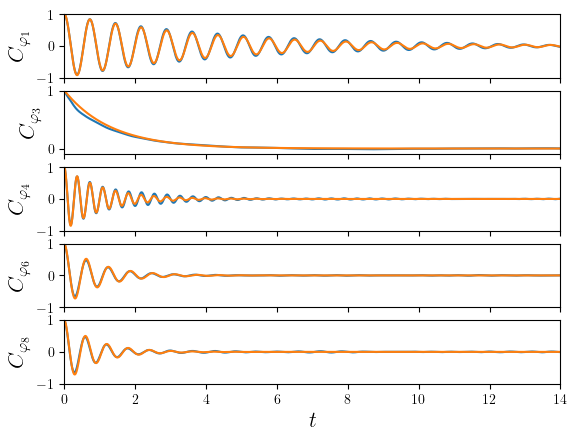

In [ ]:
fig , ax = plt.subplots(len(numbers),sharex=True)
nlags = 1500
Dt = lorenz_cf_traj.dt * lorenz_cf_traj.tau * edmd.flight_time
for i,number in enumerate(numbers):
    lags, cf = get_acf(PHI[:,number], nlags = nlags,Dt=Dt)
    cf_th = np.real(np.exp(lambdas[number]*lags))
    ax[i].plot(lags,cf/cf[0])
    ax[i].plot(lags,cf_th /cf_th[0] )
    ax[i].set_xlim(0,14)
    
    ax[i].set_ylim(-1,1)
    if i ==1 :
        ax[i].set_ylim(-0.1,1)
    ax[i].set_ylabel(fr"$C_{{ \varphi_{number} }}$",size=16)
ax[-1].set_xlabel("$t$",size=16)    
#fig.savefig("Correlation_function_Koopman_eigenfunctions.png",dpi=600)

(0.0, 15.0)

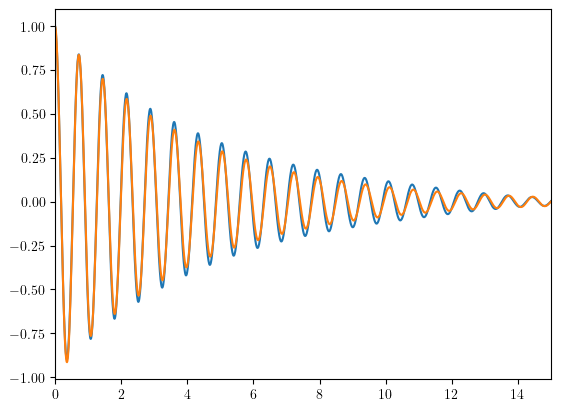

In [41]:
fig , ax = plt.subplots()
nlags = 5000
Dt = lorenz_cf_traj.dt * lorenz_cf_traj.tau * edmd.flight_time

number = 1
lags, cf = get_acf(PHI[:,number], nlags = nlags,Dt=Dt)
cf_th = np.real(np.exp(lambdas[number]*lags))
ax.plot(lags,cf/cf[0])
ax.plot(lags,cf_th /cf_th[0] )
ax.set_xlim(0,15)


### Evaluate correlation functions of observables

In [86]:
tsvd_regulariser.Ur.shape

(816, 259)

In [371]:
projections_dictionary = np.zeros(len(edmd.indices))
projections_dictionary[1] = 1 # this is z
#projections_dictionary[16] = 1 # this is y
# projections_dictionary[17] = 1 # this is yz
#projections_dictionary[151] = 1 # this is xy, the heat transport
projections_reduced = tsvd_regulariser.Ur.T @ projections_dictionary

In [372]:
# Normal 
Gr = tsvd_regulariser.Ur.T @ edmd.G @ tsvd_regulariser.Ur
M = tsvd_regulariser.reduced_right_eigvecs.conj().transpose() @ Gr @ tsvd_regulariser.reduced_right_eigvecs
koop_proj = tsvd_regulariser.reduced_left_eigvecs.T.conj() @ projections_reduced

In [467]:
tau_threshold = -5
indx = np.where(np.real(lambdas) > tau_threshold)[0] 
lambdas_good = lambdas[indx]
V = tsvd_regulariser.reduced_right_eigvecs[:,indx]
W = tsvd_regulariser.reduced_left_eigvecs[:,indx]

In [468]:
# Full Truncation 
koop_proj_good = W.T.conj() @ projections_reduced
M_good = V.T.conj() @ Gr @ V

In [469]:
# Projection onto the first eigenmodes
P = V.copy()
Q = np.linalg.pinv(V).conj().T

K_proj = Q.T.conj() @ tsvd_regulariser.Kreduced @ P
G_proj = Q.T.conj() @ Gr @ P
l , vl, vr = get_spectral_properties(K_proj)
eigs = np.log(l) / (lorenz.dt * lorenz.tau * edmd.flight_time)
#projections_reduced_double = Q.T.conj() @ projections_reduced
#M_proj = P.T.conj() @ Gr @ P
#alpha_reduced = Q.T.conj() @ projections_reduced
#S = Q.conj().T @ Gr @ Q

alpha_reduced = np.linalg.pinv(P.T.conj() @ Gr @ P) @ V.conj().T @ Gr @ projections_reduced

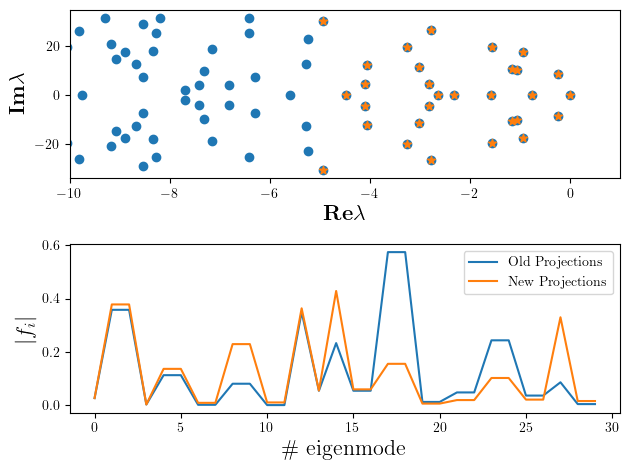

In [470]:
fig, ax = plt.subplots(nrows=2)
ax[0].scatter(np.real(lambdas),np.imag(lambdas))
ax[0].scatter(np.real(eigs), np.imag(eigs),marker="*")
ax[0].set_xlabel(r"$\mathbf{Re}\lambda$",size=16)
ax[0].set_ylabel(r"$\mathbf{Im}\lambda$",size=16)
ax[0].set_xlim(-10,1)

ax[1].plot(np.abs(koop_proj_good),label="Old Projections")
ax[1].plot(np.abs(alpha_reduced), label = "New Projections")
ax[1].legend()
ax[1].set_xlabel(r"\# eigenmode",size=16)
ax[1].set_ylabel(r"$|f_i|$",size=16)
fig.tight_layout()
fig.savefig("Projections_high.png",dpi=600)

(-10.0, 1.0)

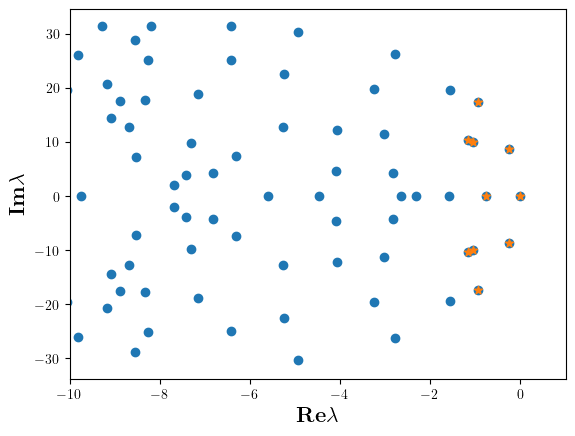

In [465]:
plt.scatter(np.real(lambdas),np.imag(lambdas))
plt.scatter(np.real(eigs), np.imag(eigs),marker="*")
plt.xlabel(r"$\mathbf{Re}\lambda$",size=16)
plt.ylabel(r"$\mathbf{Im}\lambda$",size=16)
plt.xlim(-10,1)
#plt.savefig("Spectrum.png",dpi=600)

In [434]:
def Koopman_correlation_function(t,M,alpha1,alpha2,eigenvalues,to_include = None):
    if to_include is None:
        to_include = len(eigenvalues)
        
    alpha1 = alpha1[1:to_include+1]
    alpha2 = alpha2[1:to_include+1]
    eigenvalues = eigenvalues[1:to_include+1]
    M = M[1:to_include+1,1:to_include+1]
    return ( ( alpha1* np.exp(t*eigenvalues) ) @ M @ np.conj(alpha2) )

In [435]:
K_corr = lambda t : Koopman_correlation_function(t,M,koop_proj,koop_proj,lambdas)
K_corr_good = lambda t: Koopman_correlation_function(t,M_good,koop_proj_good,koop_proj_good,lambdas_good)
K_corr_proj = lambda t: Koopman_correlation_function(t,M_good,alpha_reduced,alpha_reduced,eigs )

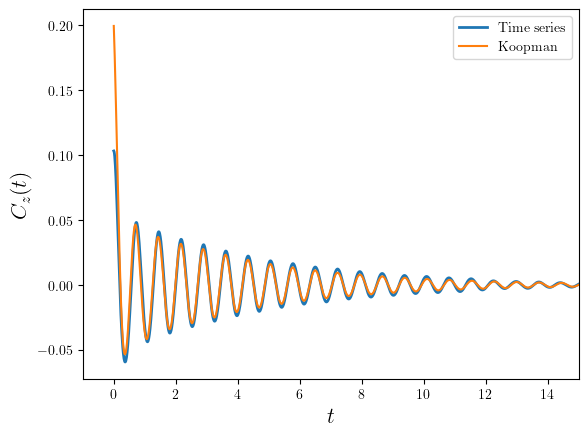

In [436]:
x,y,z = scaled[:,0] , scaled[:,1] , scaled[:,2]
lags, cf = get_acf(z, nlags = nlags,Dt=Dt)
plt.plot(lags,cf  ,label="Time series",linewidth=2)
#plt.plot(lags,np.real( [K_corr_good(lag) for lag in lags])   ,label="Koopman reconstruction")
plt.plot(lags,np.real([K_corr_proj(lag) for lag in lags]), label = "Koopman")

plt.xlim(-1,15)
plt.xlabel(r"$t$",size=16)
plt.ylabel(r"$C_{z}(t)$",size=16)
plt.legend()
#plt.ylim(-0.2,0.2)
#plt.savefig("Correlation_function_heat_transport.png",dpi=600)